<a href="https://colab.research.google.com/github/j0ngle/Machine-Learning-Projects/blob/main/PGGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Modification of my DCGAN to implement progressive growth. Progressive growth is the technique of generating very small images (4x4) for a while, then increading the size iteratively until a high resulution image is acheived. This is done by increasing the number of layers in the architecture during training.

Trained to replicate landscape paintings from [this](https://www.kaggle.com/ipythonx/wikiart-gangogh-creating-art-gan) dataset. 

TODO: 

1. ~~Build new architecture~~

  a. ~~Build architecture with predefined convolutional layers~~

  b. ~~Update conv layers with weighted layers for equalized lr~~

  c. ~~Implement minibatch std on D~~

  d. ~~Implement pixel normalization on G~~

2. Support for layer additions using skips and additions

  a. ~~Write G fade function~~

  b. ~~Write D fade function~~

  c. Create training loop

3. Initial testing

4. Minibatch standard deviation

5. Hyperparameter tuning


# Getting and processing the data

I ran this code locally to remove all images that had undesireable aspect ratios and small sizes. Then I manually removed some bad images, leaving about 1500 for training.

I'll start by scaling them to an adequate size of 64x64 and perform some image augmentation to broaden the size of my dataset

In [ ]:
import numpy as np
import cv2
import os
import urllib
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import backend

The output activation funtion for the generator is tanh, which outputs values from -1 to 1. As such, we need to normalize our images to satisfy this range

In [ ]:
def process_batch(path, size):
  processed = []
  i = 0

  print("Processing all images in {}".format(path))
  print("Scaling to {}x{} pixels".format(size, size))

  for filename in os.listdir(PATH):
    if filename.endswith('jpg'):
      if i % 500 == 0:
        print("Processed {} images".format(i))

      img = None
      img = process_image(path + filename, size)

      processed.append(img)
      i += 1

  return np.asarray(processed)

def process_image(img_path, size):
  #Convert Image to numpy array
  img = cv2.imread(img_path)

  #Resize the image
  img = cv2.resize(img, dsize=(size, size), interpolation=cv2.INTER_CUBIC)

  #Normalize image
  img = (img - 127.5) / 127.5

  return img.astype(np.float32)


def show_image(image):
  #Readjusted pixel values (convert from [-1, 1] to [0, 1]) 
  image_adjusted = (image * 127.5 + 127.5) / 255.
  plt.imshow(image_adjusted, cmap='binary')
  plt.axis('off')
  plt.show()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):

        image_adjusted = (image * 127.5 + 127.5) / 255.

        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image_adjusted, cmap='binary')
        plt.axis("off")

In [ ]:
PATH = '/content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/reduced_landscape/'

# landscapes = process_batch(PATH, 4)
# plot_multiple_images(landscapes[:40], n_cols=8)

# Creating the model

In [ ]:
#Hyperparameters
SAMPLE_SIZE      = 1000
BATCH_SIZE       = 32
LEAKY_SLOPE      = 0.2
DROPOUT          = 0.4
CODINGS_SIZE     = 128 #Might increase size later
FILTERS          = [512, 256, 128, 64, 32, 16, 8, 4]
WEIGHT_STD       = 0.02
WEIGHT_MEAN      = 0
LEARNING_RATE_G  = 0.0001
LEARNING_RATE_D  = 0.0002
scaled_size      = 4

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
def prepare_dataset(path, img_size):
  images = process_batch(path, img_size)
  dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(SAMPLE_SIZE)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset.prefetch(1)

  return dataset

In [ ]:
dataset = prepare_dataset(PATH, 4)

Processing all images in /content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/reduced_landscape/
Scaling to 4x4 pixels
Processed 0 images
Processed 500 images
Processed 1000 images


Defining custom classes

**Weight Scaling**: Since the model is so frequently changing, there is no need to initialize weights to anything other than N(0, 1). As the number of parameters increases, the dynamic range of the model changes as well. Adam and RMASProp update gradients according to the dynamic range of the model. Since it is always changing, they don't work the best

We can help this along by equalizing the learning rate with some math. Scaling the parameters as such stddev = sqrt(2 / fan_in) ensures that all weight parameters have the same dynamic range

**Pixel Normalization**: Use similarly to batch normalization. Helps prevent signal magnitudes from spiraling out of control during training

**Minibatch**: Helps prevent mode collapse by looking a group of generated images simultaneously, rather than one at a time. Some math is performed to determine how similar or different these images are from one another. If the images are too similar, the discriminator is able to judge all images as negative quickly, punishing the generator for creating images with little variety

**Weighted Sum**: When adding new layers to G and D, we must first gradually fade in the outputs. We do this by adding the outputs of a scaled up version of the old G and D to the outputs of the new ones. The contribution of each network is determined by alpha. The new model started by contributing very little to the output and eventually begins contributing 100% to the output.

WeightedSum is treated as its own layer, so we can simply attach the two models to a WeightedSum object

In [ ]:
class WeightScaling(keras.layers.Layer):
  def __init__(self, shape, gain=np.sqrt(2), **kwargs):
    super(WeightScaling, self).__init__(**kwargs)
    shape = np.asarray(shape)
    shape = tf.constant(shape, dtype=tf.float32)
    fan_in = tf.math.reduce_prod(shape)
    self.wscale = gain * tf.math.rsqrt(fan_in)

  def call(self, inputs, **kwargs):
    inputs = tf.cast(inputs, tf.float32)

    return inputs * self.wscale

  def compute_output_shape(self, input_shape):
    return input_shape

class PixelNormalization(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(PixelNormalization, self).__init__(**kwargs)

  def call(self, inputs):
    mean_square = tf.reduce_mean(tf.square(inputs), axis=-1, keepdims=True)
    l2 = tf.math.rsqrt(mean_square + 1.0e-8)
    
    return inputs * l2

  def compute_output_shape(self, input_shape):
    return input_shape

class Minibatch(keras.layers.Layer):
  def __init__(self, **kwargs):
    super(Minibatch, self).__init__(**kwargs)

  def call(self, inputs):
    mean = tf.reduce_mean(inputs, axis=0, keepdims=True)
    stddev = tf.sqrt(tf.reduce_mean(tf.square(inputs - mean), axis=0, keepdims=True) + 1e-8)
    avg_stddev = tf.reduce_mean(stddev, keepdims=True)
    shape = tf.shape(inputs)
    minibatch = tf.tile(avg_stddev, (shape[0], shape[1], shape[2], 1))
    
    return tf.concat([inputs, minibatch], axis=-1)

  def compute_output_shape(self, input_shape):
    input_shape = list(input_shape)
    input_shape[-1] += 1
    
    return tuple(input_shape)

class WeightedSum(keras.layers.Add):
  def __init__(self, alpha=0.0, **kwargs):
    super(WeightedSum, self).__init__(**kwargs)
    self.alpha = backend.variable(alpha, name='ws_alpha')

  def _merge_function(self, inputs):
    assert (len(inputs) == 2)
    output = ((1.0 - self.alpha) * inputs[0] + (self.alpha * inputs[1]))

    return output

Note: I omitted custom bias layer in favor of simply toggling ```use_bias = True```



In [ ]:
def WS_Dense(model, filters, gain, use_pixelnorm=False, activation=None):
  init = keras.initializers.RandomNormal(mean=0, stddev=1.)
  in_filters = backend.int_shape(model)[-1]

  model = keras.layers.Dense(filters, use_bias=True, kernel_initializer=init, dtype='float32')(model)
  model = WeightScaling(shape=(in_filters), gain=gain)(model)

  if activation == 'LeakyReLU':
    model = keras.layers.LeakyReLU(LEAKY_SLOPE)(model)
  elif activation == 'tanh':
    model = keras.layers.activation('tanh')(model)

  if use_pixelnorm:
    model = PixelNormalization()(model)

  return model

def WS_Conv(model, filters, k_size, strides, gain, use_pixelnorm, activation):
  init = keras.initializers.RandomNormal(mean=0, stddev=1.)
  in_filters = backend.int_shape(model)[-1]

  model = keras.layers.Conv2D(filters, kernel_size=k_size, strides=strides, 
                          use_bias=True, padding='same', kernel_initializer=init,
                          dtype='float32')(model)
  model = WeightScaling(shape=(k_size[0], k_size[1], in_filters), gain=gain)(model)

  if activation == 'LeakyReLU':
    model = keras.layers.LeakyReLU(LEAKY_SLOPE)(model)
  elif activation == 'tanh':
    model = keras.layers.Activation('tanh')(model)

  if use_pixelnorm:
    model = PixelNormalization()(model)
  
  return model

These are the initial states for G and D. They are designed to generate (and discriminate) 4x4 images. Their capabilities will be expanded in the grow generator and grow discriminator functions

In [ ]:
def init_generator():
  input_ = keras.layers.Input(shape=(CODINGS_SIZE,))

  model = PixelNormalization()(input_)

  model = WS_Dense(model, 4*4*FILTERS[0], gain=np.sqrt(2)/4, 
                   activation='LeakyReLU', use_pixelnorm=True)

  model = keras.layers.Reshape([scaled_size, scaled_size, FILTERS[0]])(model)
  
  model = WS_Conv(model, filters=FILTERS[0], k_size=(4, 4), strides=(1, 1), 
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=True)
  model = WS_Conv(model, filters=FILTERS[0], k_size=(3, 3), strides=(1, 1), 
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=True)


  model = WS_Conv(model, filters=3, k_size=(1, 1), strides=(1, 1), gain=1,
                  activation='tanh', use_pixelnorm=False)   #toRGB
  
  generator = keras.Model(input_, model, name='generator')

  return generator

def init_discriminator():
  input_ = keras.layers.Input(shape=(4, 4, 3))
  # input_ = tf.cast(input_, tf.float32)

  model = WS_Conv(input_, FILTERS[0], k_size=(1, 1), strides=(1, 1), 
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False) #fromRGB

  model = Minibatch()(model)

  model = WS_Conv(model, FILTERS[0], k_size=(3, 3), strides=(1, 1), 
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False)
  model = WS_Conv(model, FILTERS[0], k_size=(4, 4), strides=(4, 4), 
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False)

  model = keras.layers.Flatten()(model)

  model = WS_Dense(model, filters=1, gain=1.)

  discriminator = keras.Model(input_, model, name='discriminator')

  return discriminator

In [ ]:
generator = init_generator()
discriminator = init_discriminator()

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 128)]             0         
_________________________________________________________________
pixel_normalization_24 (Pixe (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 8192)              1056768   
_________________________________________________________________
weight_scaling_64 (WeightSca (None, 8192)              0         
_________________________________________________________________
leaky_re_lu_52 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
pixel_normalization_25 (Pixe (None, 8192)              0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 4, 4, 512)         0 

In [ ]:
print(generator.layers[-4])
print()
generator.layers

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 4, 4, 3)]         0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 4, 4, 512)         2048      
_________________________________________________________________
weight_scaling_68 (WeightSca (None, 4, 4, 512)         0         
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 4, 4, 512)         0         
_________________________________________________________________
minibatch_2 (Minibatch)      (None, 4, 4, 513)         0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 4, 4, 512)         2364416   
_________________________________________________________________
weight_scaling_69 (WeightSca (None, 4, 4, 512)       

In [ ]:
print(discriminator.layers[4])
print(len(discriminator.layers))


14


Next we want to define functions for fading new blocks into G and D

**G Process**:

The fade block goes right above the existing toRGB block
  
1. Get node above 'toRGB' block as `block`

2. Use upsampling to double the above

3. Reuse existing 'toRGB' as `old_G`

  a. Attach to `block`

4. Define a fade in block as `new_G` and add a new 'toRGB' (filters should be derived from depth parameter)

5. Define `new_G` generator (stablized generator)

6. Find the weighted sum of `old_G` and `new_G`

**D Process**:

1. Double input resolution

2. Add a pooling layer to downscale the new input resolution as `old_D`

  a. Reuse 'fromRGB' block

3. Define a fade in block as `new_D`

4. Calculate the weighted sum of `old_D` and `new_D`

5. Define new D

6. Add existing D layers

In [ ]:
def fade_G(generator, depth):
  #Double generated image size
  block = generator.layers[-4].output               #pixel_normalization_7
  block = keras.layers.UpSampling2D((2, 2))(block)  #Doubling using upscaling

  #Grabbing old output
  old_G = generator.layers[-3](block)               #conv2d_8        
  old_G = generator.layers[-2](old_G)               #weight_scaling_11
  old_G = generator.layers[-1](old_G)               #activation_1 

  #New block
  new_G = WS_Conv(block, filters=FILTERS[depth], k_size=(3, 3), strides=(1, 1),
                    gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=True)
  new_G = WS_Conv(new_G, filters=FILTERS[depth], k_size=(3, 3), strides=(1, 1),
                    gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=True)
  new_G = WS_Conv(new_G, filters=3, k_size=(1, 1), strides=(1, 1),
                    gain=1., activation='tanh', use_pixelnorm=False)  #linear in paper
  
  #G_stable = keras.Model(generator.input, new_G, name='generator')

  #New generator that outputs the weighted sum of both old and new G
  new_generator = WeightedSum()([old_G, new_G])

  #Compile
  new_generator = keras.models.Model(generator.input, new_generator, name='generator')

  return new_generator#, G_stable

def fade_D(discriminator, depth):
  #Double out input shape
  input_shape = list(discriminator.input.shape)
  input_shape = (input_shape[1]*2, input_shape[2]*2, input_shape[3])

  new_input_ = keras.layers.Input(shape=input_shape)
  # new_input_ = tf.cast(new_input_, tf.float32)

  #Grab old input from D
  old_D = keras.layers.AveragePooling2D()(new_input_) #Downscale input
  old_D = discriminator.layers[1](old_D)              #conv2d_3
  old_D = discriminator.layers[2](old_D)              #weight_scaling_4
  old_D = discriminator.layers[3](old_D)              #leaky_re_lu_3

  #Define new D with double input
  new_D = WS_Conv(new_input_, filters=FILTERS[depth], k_size=(1, 1), strides=(1, 1),
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False)
  new_D = WS_Conv(new_D, filters=FILTERS[depth], k_size=(3, 3), strides=(1, 1),
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False)
  new_D = WS_Conv(new_D, filters=FILTERS[depth-1], k_size=(3, 3), strides=(1, 1),
                  gain=np.sqrt(2), activation='LeakyReLU', use_pixelnorm=False)
  new_D = keras.layers.AveragePooling2D()(new_D)

  #New D with weightedSum
  new_discriminator = WeightedSum()([old_D, new_D])

  #Rebuild stable D
  # for i in range(4, len(discriminator.layers)):
  #   new_D = discriminator.layers[i](new_D)
  # D_stable = keras.Model(new_input_, new_D, name='discriminator')

  #Connect new D with remaining layers from old
  for i in range(4, len(discriminator.layers)):
    new_discriminator = discriminator.layers[i](new_discriminator)
  new_discriminator = keras.models.Model(new_input_, new_discriminator, name='discriminator')

  return new_discriminator#, D_stable

Testing that the models were compiled correctly

The Generator should not produce a black box since the weights were not normalized to be relatively zero-centered. This is by design

The Discriminator should predict the generated image with a probability of about 0.5 since it is untrained

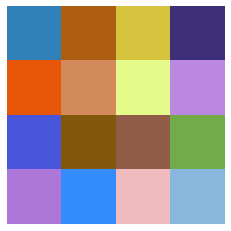

(1, 4, 4, 3)


In [ ]:
noise = tf.random.normal([1, CODINGS_SIZE])

generated_image = generator(noise)

show_image(generated_image[0, :, :, :])
print(generated_image.shape)

In [ ]:
print(discriminator(generated_image))

tf.Tensor([[0.43090957]], shape=(1, 1), dtype=float32)


# Training the Model

**Label Smoothing** prevents the discriminator from being either over confident or underconfident in its predictions.

Essentially if the discriminator is too certain that there is a dog in a given image, the generator can exploit that and contiuously generate similar images, thus it'll stop improving.

This can be combatted by setting the

1. Negative Class labels to a range [0, 0.3]
2. Postitive Class labels to a range [0.7, 1]

**Instance Noise** adds a small amount of error to the labels, which tends to make the true and predicted distributions more spread out.

Instance Noise makes the learning process for the generator easier

ngl idk exactly how this algorithm works, but it does the above

In [ ]:
def smooth_labels(y, label_type):
  if label_type is 'positive':
    return y - 0.3 + (np.random.random(y.shape) * 0.5)
  elif label_type is 'negative':
    return y + np.random.random(y.shape) * 0.3
  else:
    raise ValueError('Expected "positive" or "negative" for label_type. Recieved:', label_type)

def noisy_labels(y, p_flip):
  length = int(y.shape[0])

  num_labels = int(p_flip * length)

  i_flip = np.random.choice([i for i in range(length)], size=num_labels)

  op_list = []
  for i in range(length):
    if i in i_flip:
      op_list.append(tf.subtract(1, y[i]))
    else:
      op_list.append(y[i])

  outputs = tf.stack(op_list)
  return outputs

Both the generator and discriminator will use Adam optimizers, but it is possible that they could end up requiring different learning rate. Thus, we will define a unique optimizer for each of the two

In [ ]:
gen_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE_G, beta_1=.5)
disc_optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE_D, beta_1=0.5)
#disc_optimizer = keras.optimizers.SGD(learning_rate=LEARNING_RATE_D)
cross_entropy = keras.losses.BinaryCrossentropy(from_logits=False)

Defining Loss Functions

Uses Binary Crossentropy to calculate loss.

Discriminator loss: How well the discriminator was able to detect fake images

Generator loss: How well the generator was able to fool the discriminator. We apply positive (1) labels to all generated images to attempt to fool the discriminator

In [ ]:
def discriminator_loss(real_output, fake_output, apply_smoothing=True, apply_noise=True):
  real_output_mod = real_output
  fake_output_mod = fake_output

  if apply_noise:
    real_output_mod = noisy_labels(tf.ones_like(real_output_mod), 0.1)
    fake_output_mod = noisy_labels(tf.zeros_like(fake_output_mod), 0.1)
  
  if apply_smoothing:
    real_output_mod = smooth_labels(real_output_mod, 'positive')
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  #Instead of cross_entropy, try:
  #fake mean - real mean
  #Gradient penalty
  #Drift for regularization

  #Or try cross entropy
  real_loss = cross_entropy(tf.ones_like(real_output_mod), real_output) #labels, outputs
  fake_loss = cross_entropy(tf.zeros_like(fake_output_mod), fake_output)

  return real_loss + fake_loss

def generator_loss(fake_output, apply_smoothing=True):
  fake_output_mod = fake_output

  if apply_smoothing:
    fake_output_mod = smooth_labels(fake_output_mod, 'negative')

  return cross_entropy(tf.ones_like(fake_output_mod), fake_output)

In [ ]:
def plot_losses(G_loss, D_loss, G_loss_total, D_loss_total, G_mean, D_mean, epoch):
  plt.figure(figsize=(10, 5))
  plt.title("Generator and Discriminator Loss - EPOCH {}".format(epoch + 1))
  plt.plot(G_loss, label="Generator")
  plt.plot(D_loss, label="Discriminator")
  plt.xlabel("Iterations")
  plt.ylabel("Loss")
  plt.legend()
  ymax = plt.ylim()[1]
  plt.show()

  plt.figure(figsize=(10, 5))
  plt.plot(np.arange(len(G_loss_total)), G_loss_total, label='G')
  plt.plot(np.arange(len(D_loss_total)), D_loss_total, label='D')
  plt.legend()
  plt.title("All Time Loss")
  plt.show()

In [ ]:
checkpoint_dir = '/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=gen_optimizer,
                                 discriminator_optimizer=disc_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

Train_step:

1. Create noise
2. Generate images from noise
3. Feed discriminator real and fake images, record results
4. Calculate loss
5. Calculate gradients
6. Apply gradients
7. Return losses

In [ ]:
def train_step(images, d_pretrain=5, smooth=False, noise=False):
  #No pretraining
  if d_pretrain == 0:
    noise = tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Generate Images
      generated_images = generator(noise, training=True)

      #Send real and fake images through D
      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      #Calculate loss
      gen_loss = generator_loss(fake_output,
                                apply_smoothing=smooth)
      disc_loss = discriminator_loss(real_output, 
                                     fake_output, 
                                     apply_smoothing=smooth, 
                                     apply_noise=noise)

    #Get gradients
    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    #Train
    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

  #With pretrianing
  else:
    #Pretrain D for d_pretrain steps
    for i in range(d_pretrain):
      noise = tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE])

      with tf.GradientTape() as disc_tape:
        #Generate images
        generated_images = generator(noise, training=True)

        #Send real and fake images through D
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        #get D loss
        disc_loss = discriminator_loss(real_output, 
                                       fake_output, 
                                       apply_smoothing=smooth, 
                                       apply_noise=False)
        
        #Get and apply D gradients
        disc_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
        disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    #Train G
    with tf.GradientTape() as gen_tape:
      #Generate images
      generated_images = generator(noise, training=True)

      #Get D output for fake images
      fake_output = discriminator(generated_images, training=True)

      #G loss
      gen_loss = generator_loss(fake_output,
                                apply_smoothing=smooth)
      
      #Get and apply gradients
      gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
      gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))

  return gen_loss, disc_loss

def update_alpha(a, generator, discriminator):
  for layer in generator.layers:
    if isinstance(layer, WeightedSum):
      backend.set_value(layer.alpha, a)
  for layer in discriminator.layers:
    if isinstance(layer, WeightedSum):
      backend.set_value(layer.alpha, a)

In [ ]:
plot_step = 1

def train_gan(path, generator, discriminator, epochs=50):
  total_loss_G = np.array([])
  total_loss_D = np.array([])

  for depth in range(1, 7):                                                     #Iterate thorugh filters, skip [0] bc of init
    
    dataset = prepare_dataset(PATH, FILTERS[8-depth])                           #Get new dataset object with correct image sizes

    generator = fade_G(generator, depth)                                        #Establish fading layers
    discriminator = fade_D(discriminator, depth)

    depth_loss_G = np.array([])
    depth_loss_D = np.array([])

    print("Starting depth {}\n".format(depth))
    for epoch in range(epochs):
      print("Starting epoch {}/{}\n".format(epoch, epochs))

      update_alpha(epoch / epochs, generator, discriminator)

      epoch_loss_G = []
      epoch_loss_D = []

      for batch in dataset:
        g_loss, d_loss = train_step(batch, d_pretrain=3)                        #Get losses
        epoch_loss_G.append(g_loss)
        epoch_loss_D.append(d_loss)

      depth_loss_G = np.append(depth_loss_G, np.array([epoch_loss_G]))
      depth_loss_D = np.append(depth_loss_D, np.array([epoch_loss_D]))

    
      #Generate test images
      noise = tf.random.normal(shape=[BATCH_SIZE, CODINGS_SIZE])                
      generated_images = generator(noise, training=False)

      #Print and plot
      print("Generator Loss Mean:", np.mean(epoch_loss_G), "Std:", np.std(epoch_loss_G))
      print("Discriminator Loss Mean:", np.mean(epoch_loss_D), "Std:", np.std(epoch_loss_D))
      print("Alpha =", epoch / epochs)

      if ((epoch + 1) % plot_step == 0):
        # plot_losses(epoch_loss_G, epoch_loss_D, all_gl, all_dl, G_mean, D_mean, epoch)
        plot_multiple_images(generated_images, 8) 
        show_image(generated_images[0])               
        plt.show()    

    # total_loss_G = np.append(total_loss_G, np.array([depth_loss_G])
    # total_loss_D = np.append(total_loss_D, np.array([depth_loss_D])

    



Possible failures:

1. D loss goes to 0: Failure mode
2. If loss of G steadily goes down, it is fooling D with garbage images

Processing all images in /content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/reduced_landscape/
Scaling to 4x4 pixels
Processed 0 images
Processed 500 images
Processed 1000 images
Starting depth 1

Starting epoch 0/5

Generator Loss Mean: 11.732925 Std: 1.1185346
Discriminator Loss Mean: 0.29367492 Std: 0.161212
Alpha = 0.0


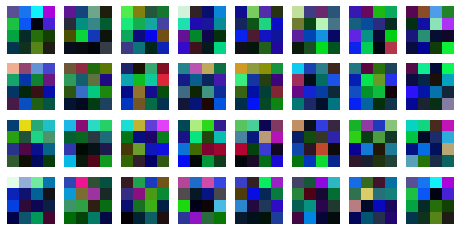

Starting epoch 1/5

Generator Loss Mean: 12.059096 Std: 1.1316538
Discriminator Loss Mean: 0.23320347 Std: 0.13211572
Alpha = 0.2


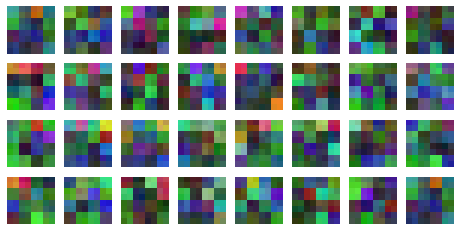

Starting epoch 2/5

Generator Loss Mean: 12.917838 Std: 0.835663
Discriminator Loss Mean: 0.18325639 Std: 0.14113584
Alpha = 0.4


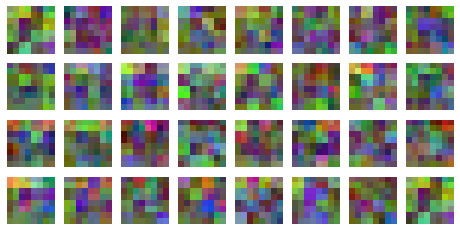

Starting epoch 3/5

Generator Loss Mean: 13.123681 Std: 0.947233
Discriminator Loss Mean: 0.16095024 Std: 0.14270212
Alpha = 0.6


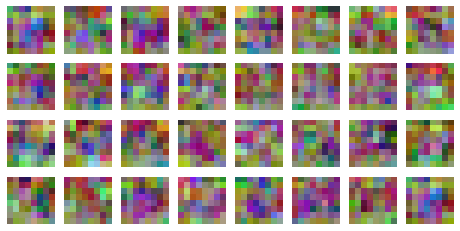

Starting epoch 4/5

Generator Loss Mean: 13.482845 Std: 1.0191989
Discriminator Loss Mean: 0.12403354 Std: 0.12682958
Alpha = 0.8


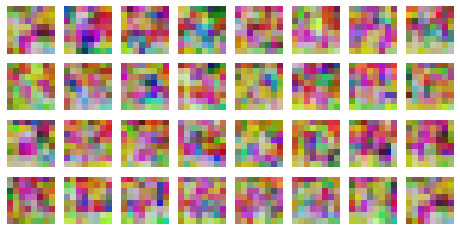

Processing all images in /content/drive/MyDrive/Summer 2021 AI Research Stuff/Colab Files/Resources/reduced_landscape/
Scaling to 8x8 pixels
Processed 0 images
Processed 500 images
Processed 1000 images


ValueError: ignored

In [ ]:
train_gan(dataset, generator, discriminator, epochs=5)